
--- Digital Communication Chat App ---
1. Text Message
2. Audio File (.wav)
3. Exit
Enter choice (1, 2, or 3): 2
Enter path to .wav file: sine_test.wav


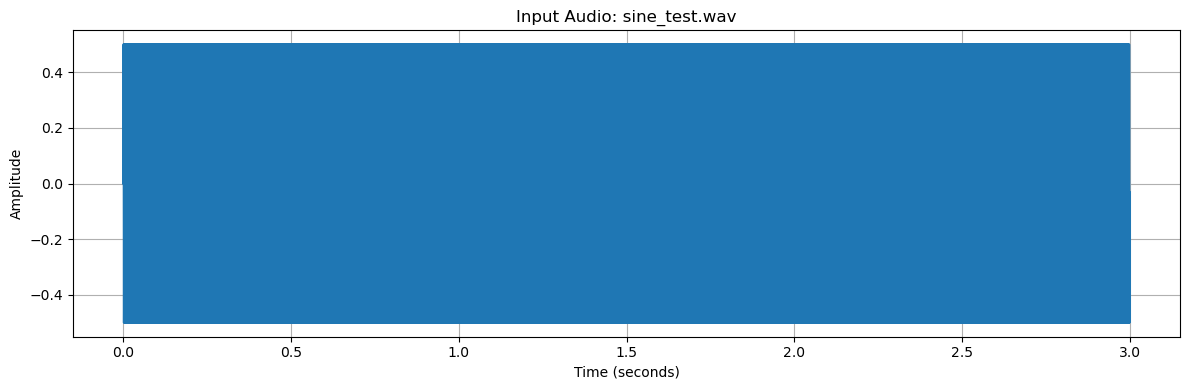

C:\Users\sahaa\AppData\Local\Temp\ipykernel_25696\2217538350.py:155: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(np.arange(len(bits)), bits, basefmt=" ", use_line_collection=True)


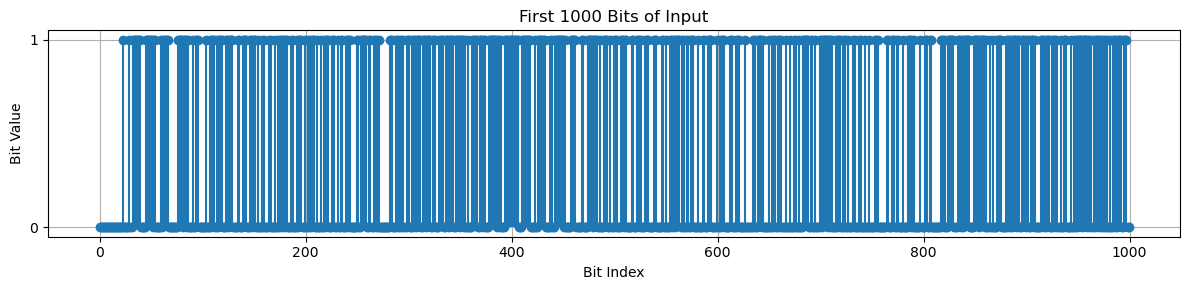

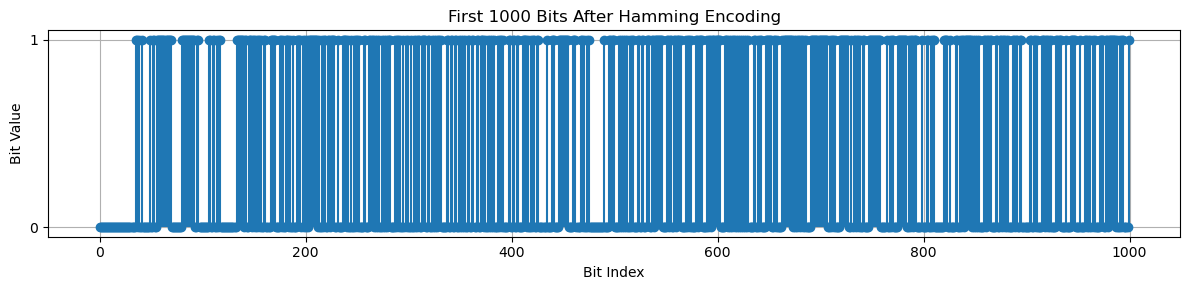


Select Modulation:
1. BPSK
2. QPSK
3. 16-QAM
Enter choice (1/2/3): 1
Enter Eb/N0 in dB (recommended 2–10, press Enter for default 5dB): 5


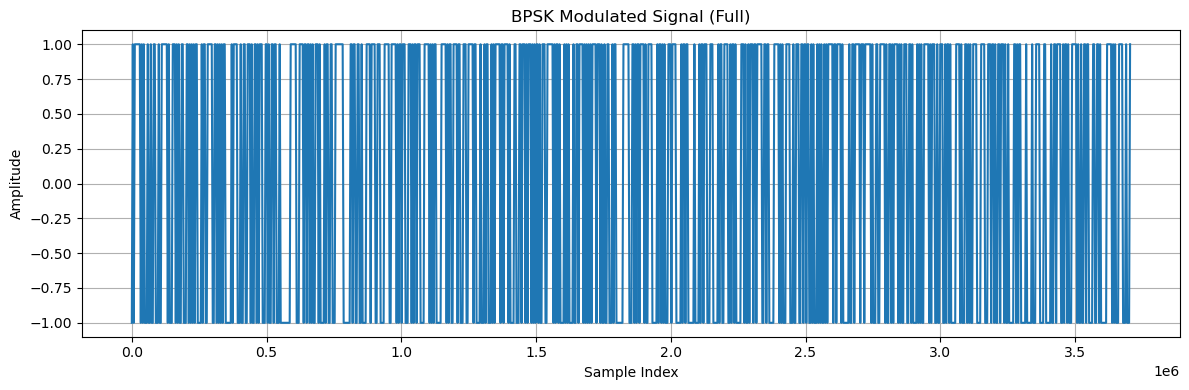

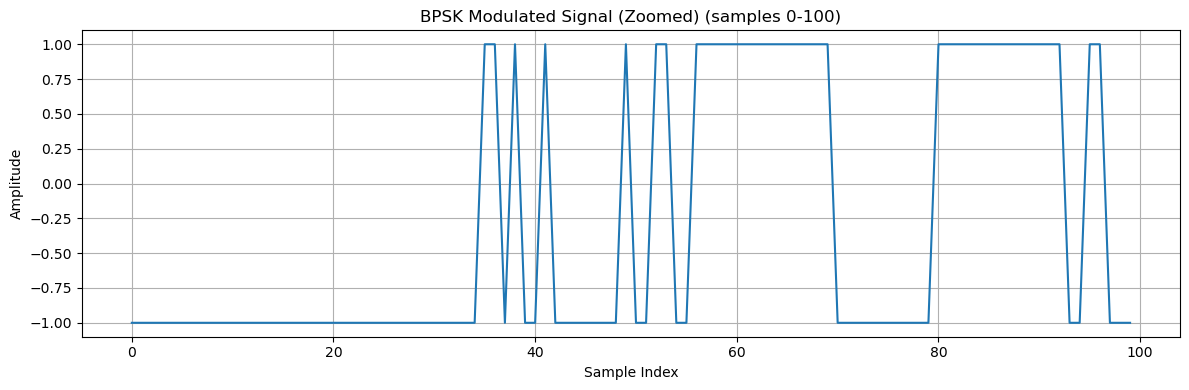

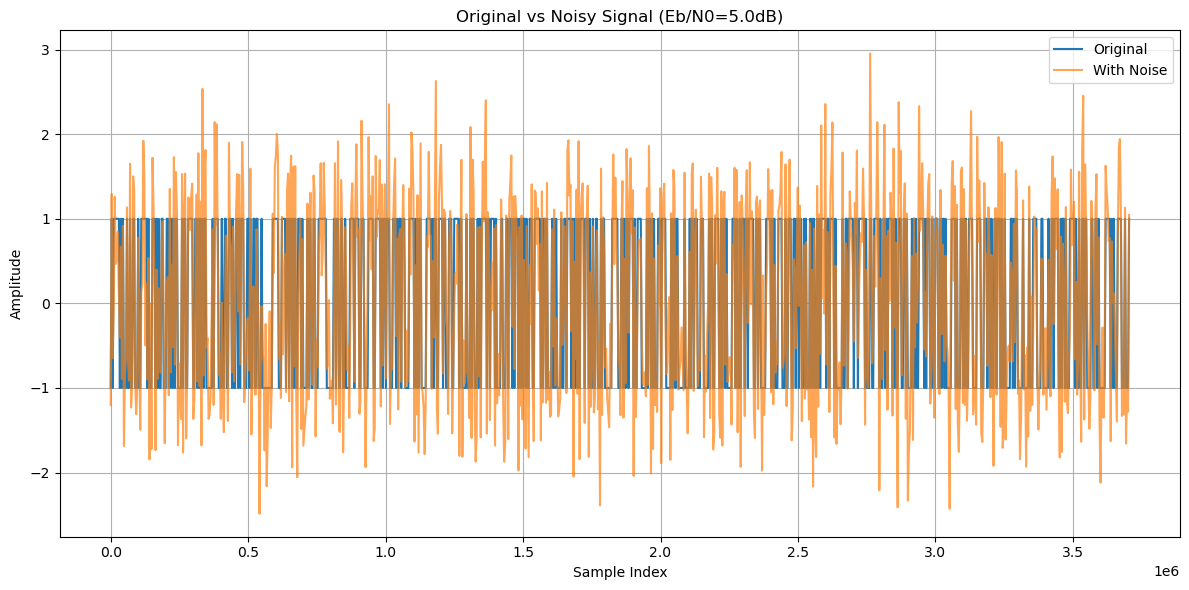

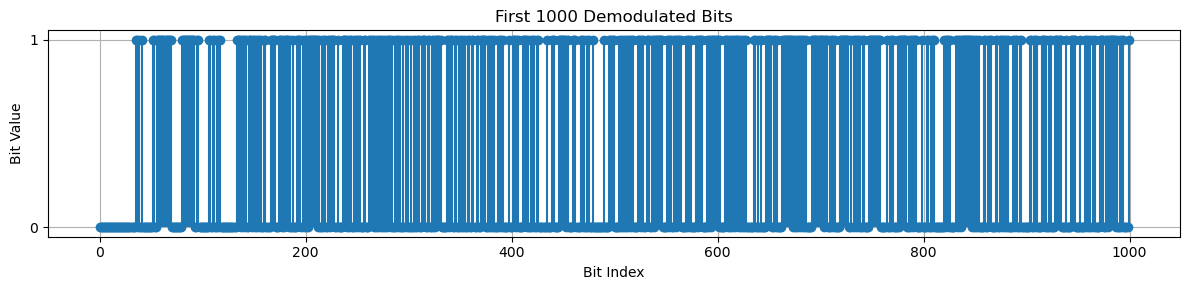

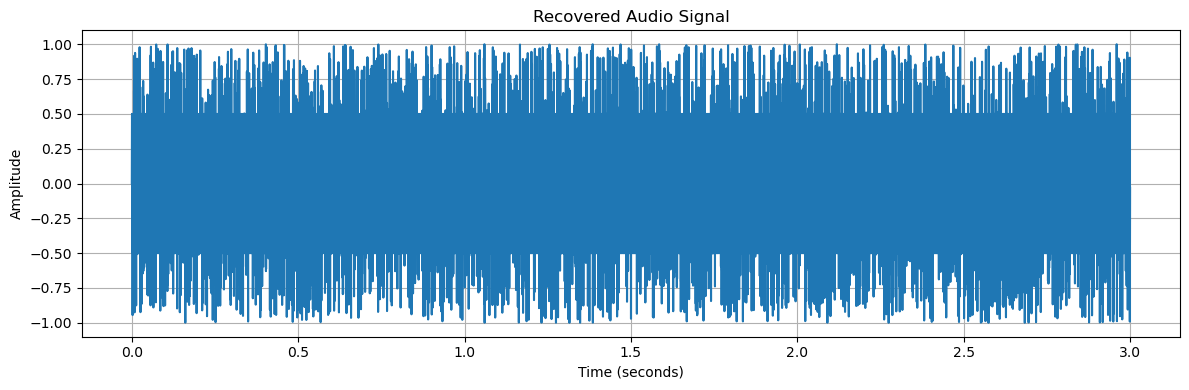

✅ Audio decoded successfully.
✅ Saved to received_output.wav

⚠️ Audio playback disabled (sounddevice module not available)

--- Digital Communication Chat App ---
1. Text Message
2. Audio File (.wav)
3. Exit
Enter choice (1, 2, or 3): 2
Enter path to .wav file: sine_wave.wav
File not found.

--- Digital Communication Chat App ---
1. Text Message
2. Audio File (.wav)
3. Exit
Enter choice (1, 2, or 3): sine_test.wav
Invalid option. Try again.

--- Digital Communication Chat App ---
1. Text Message
2. Audio File (.wav)
3. Exit
Enter choice (1, 2, or 3): 2
Enter path to .wav file: sine_test.wav


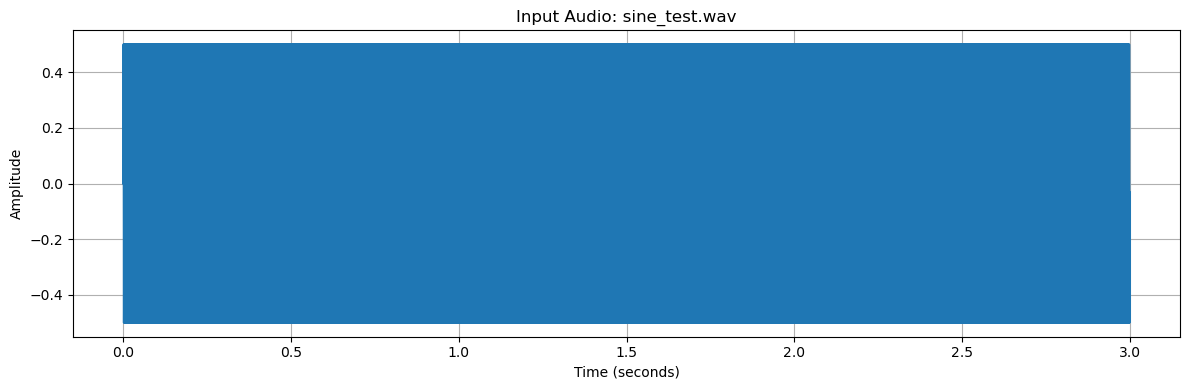

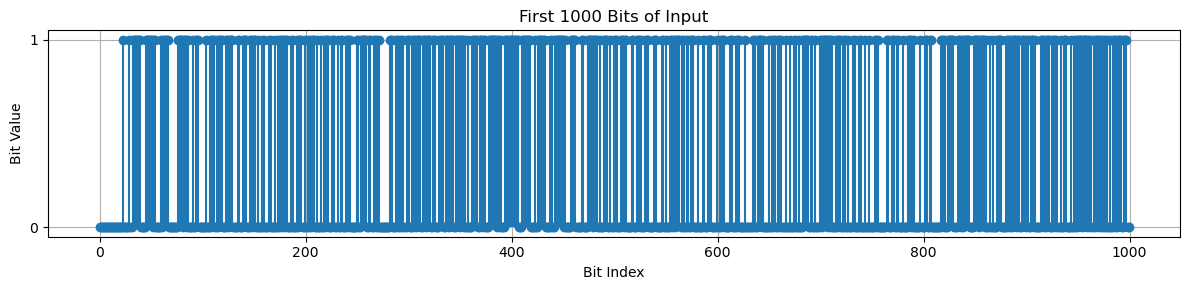

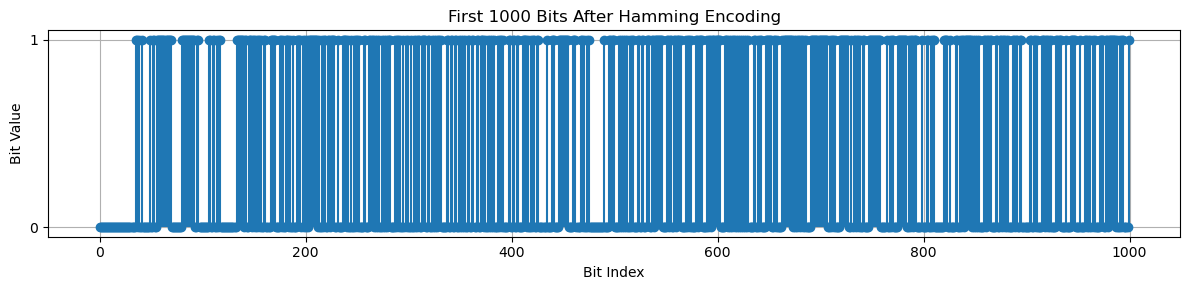


Select Modulation:
1. BPSK
2. QPSK
3. 16-QAM
Enter choice (1/2/3): 2
Enter Eb/N0 in dB (recommended 2–10, press Enter for default 5dB): 5


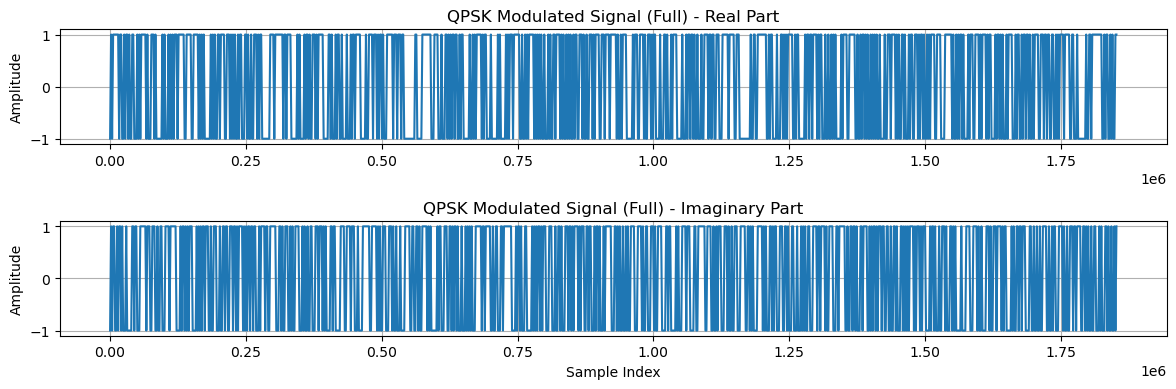

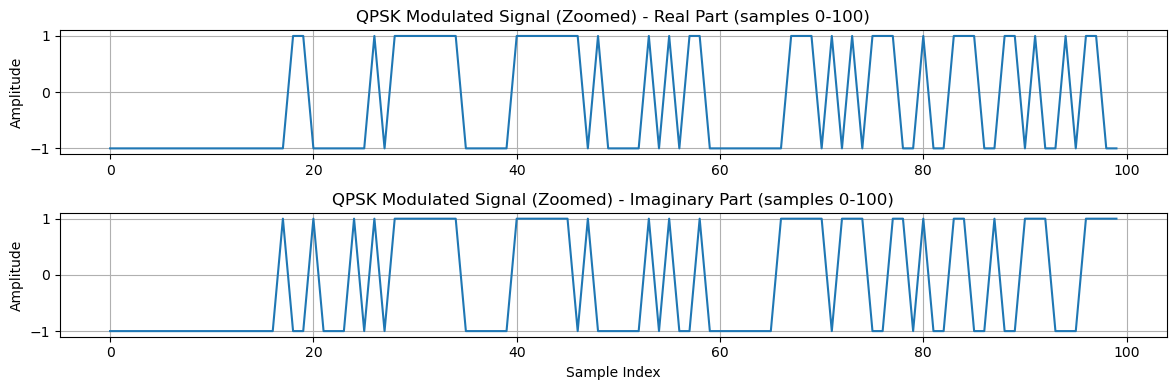

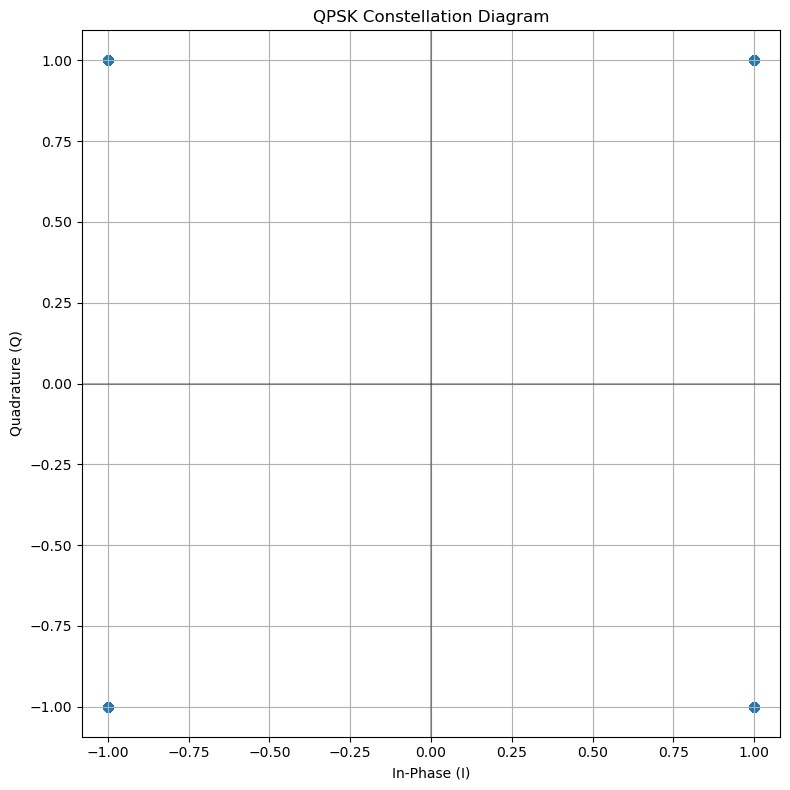

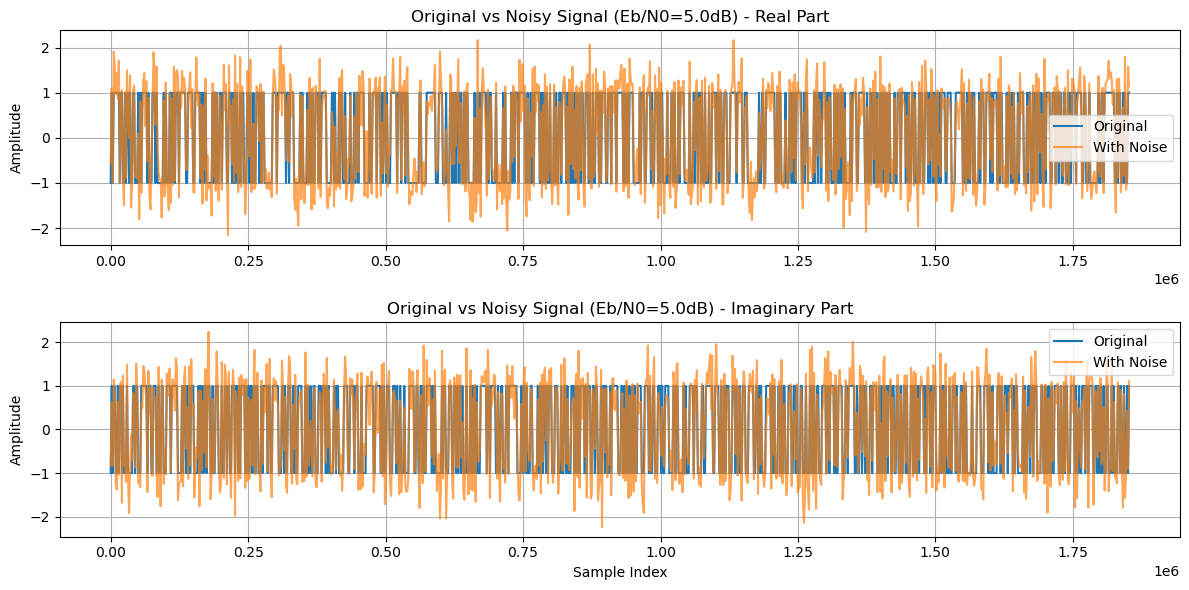

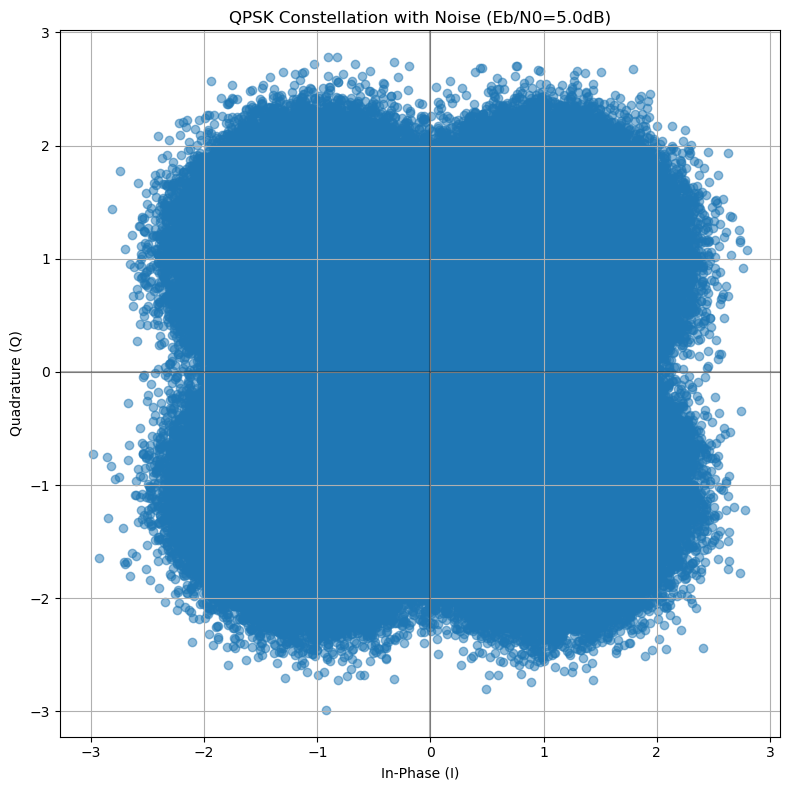

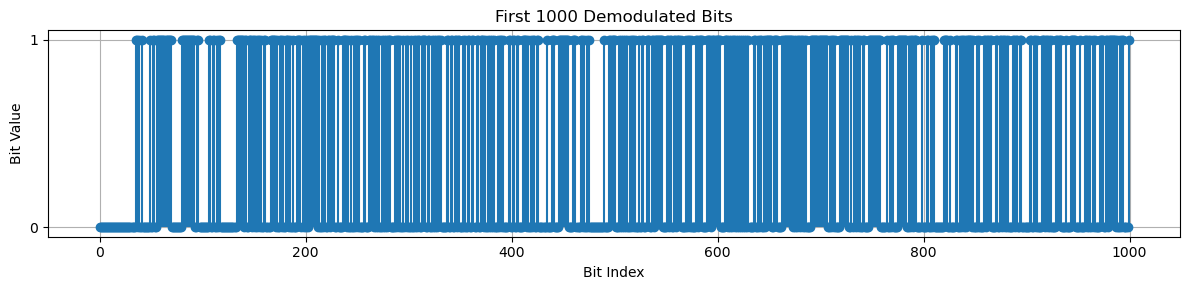

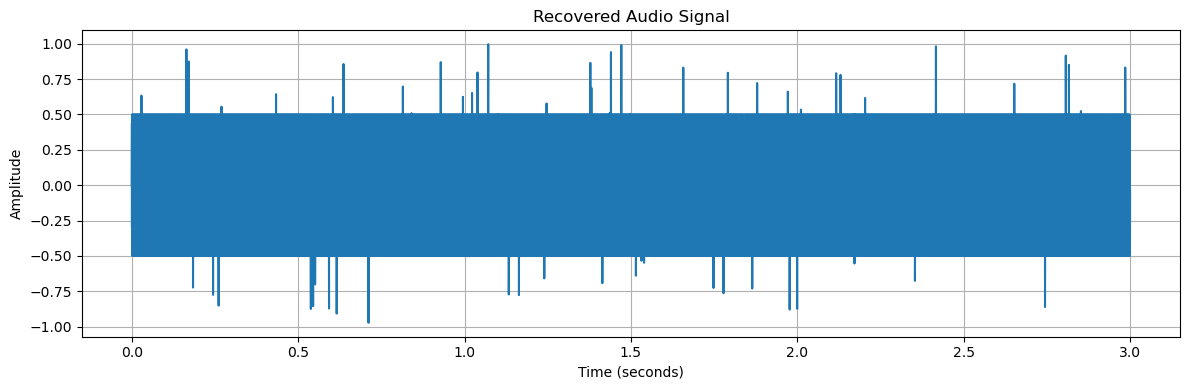

✅ Audio decoded successfully.
✅ Saved to received_output.wav

⚠️ Audio playback disabled (sounddevice module not available)

--- Digital Communication Chat App ---
1. Text Message
2. Audio File (.wav)
3. Exit
Enter choice (1, 2, or 3): 2
Enter path to .wav file: sine_test.wav


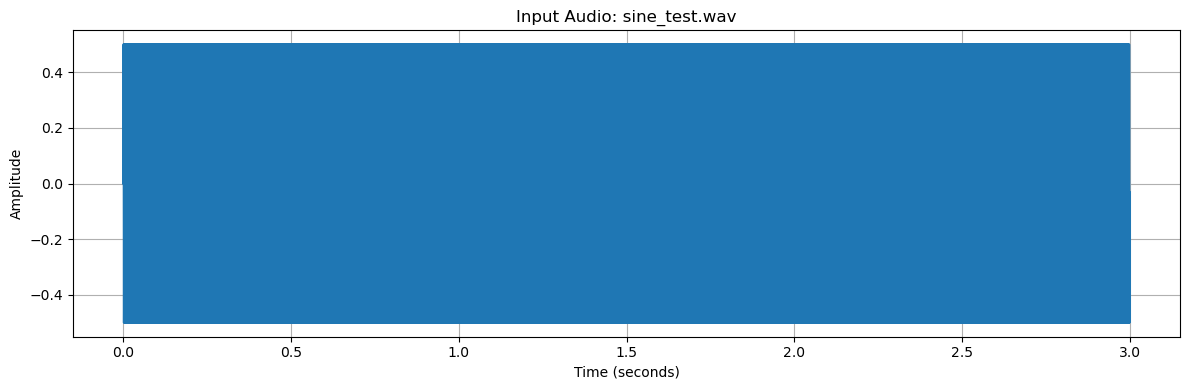

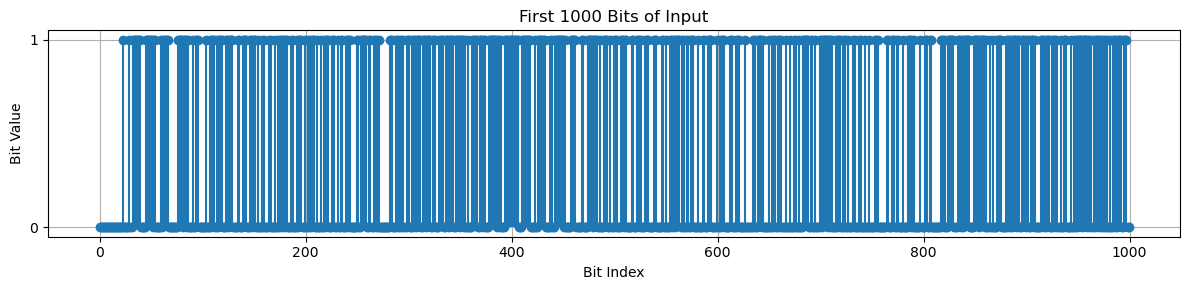

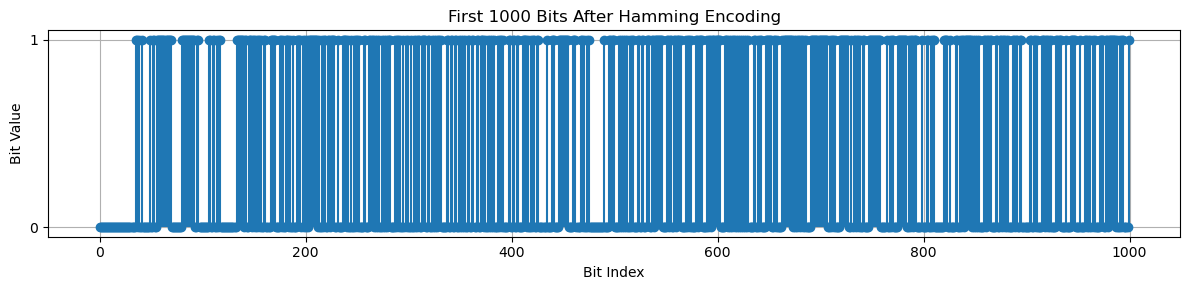


Select Modulation:
1. BPSK
2. QPSK
3. 16-QAM
Enter choice (1/2/3): 3
Enter Eb/N0 in dB (recommended 2–10, press Enter for default 5dB): 5


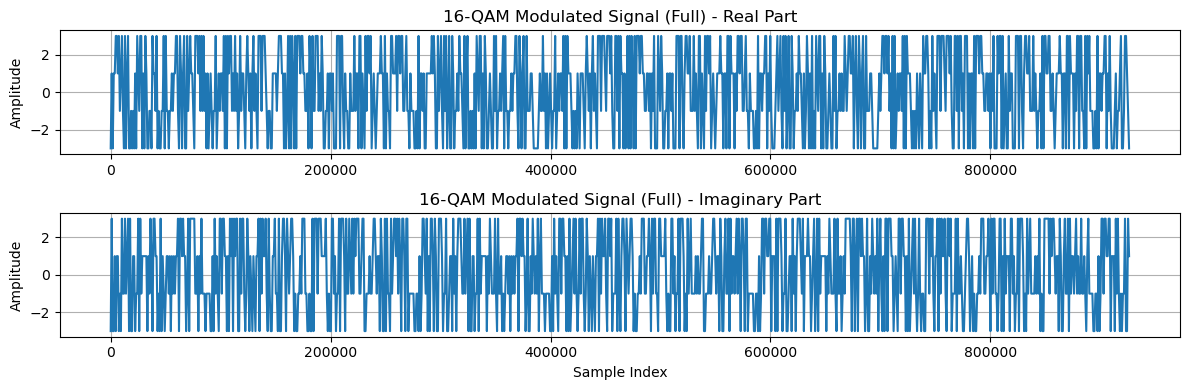

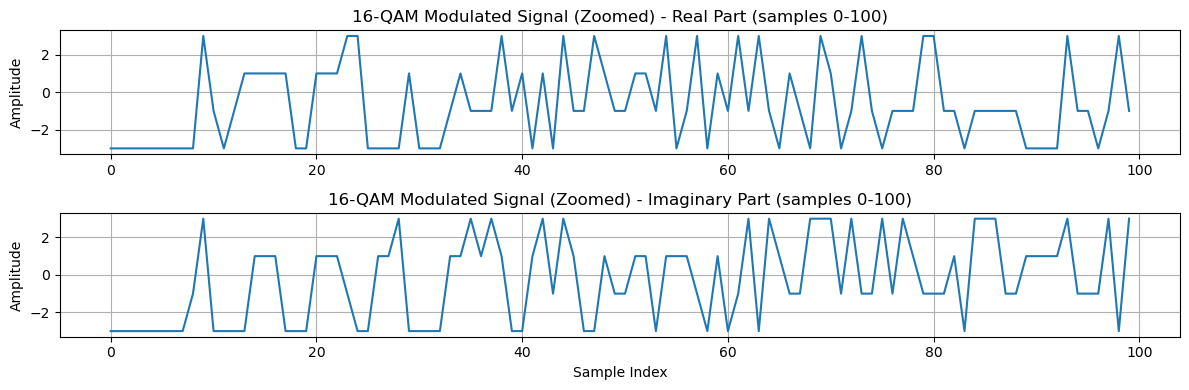

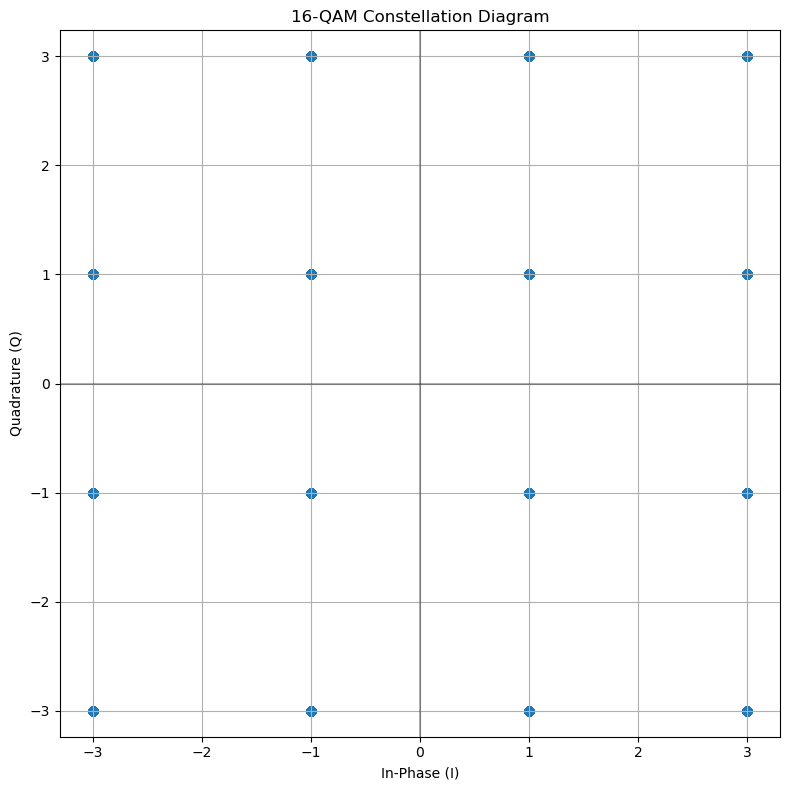

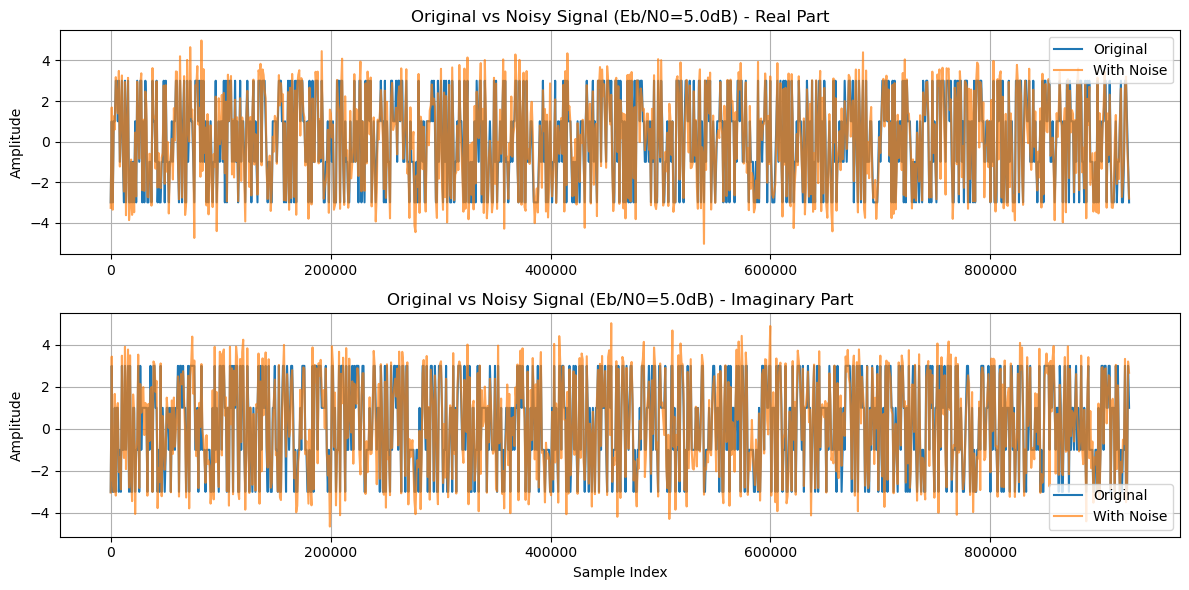

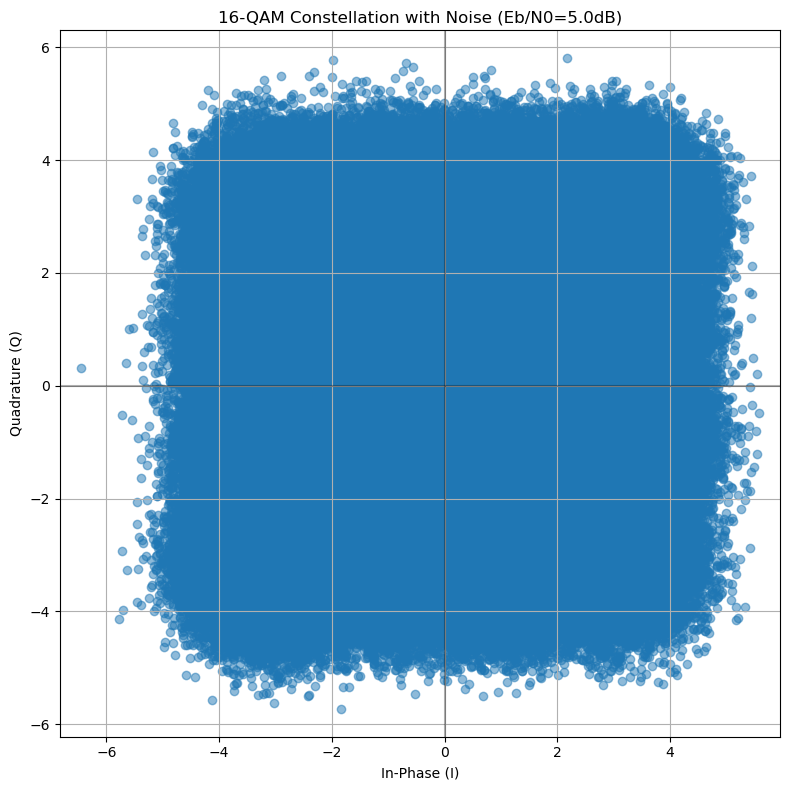

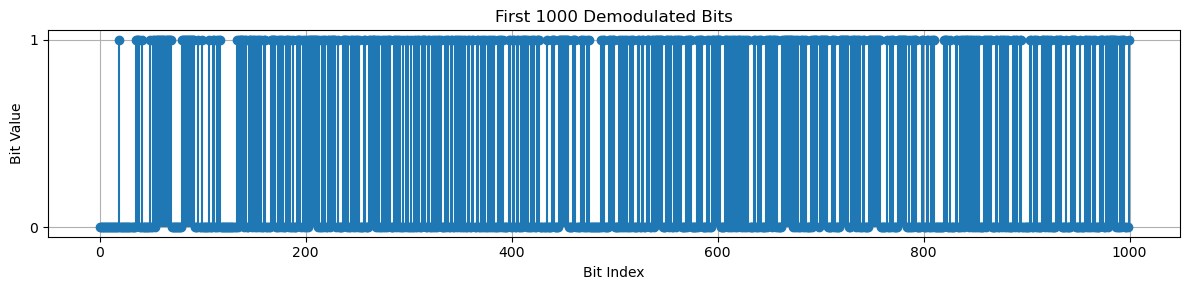

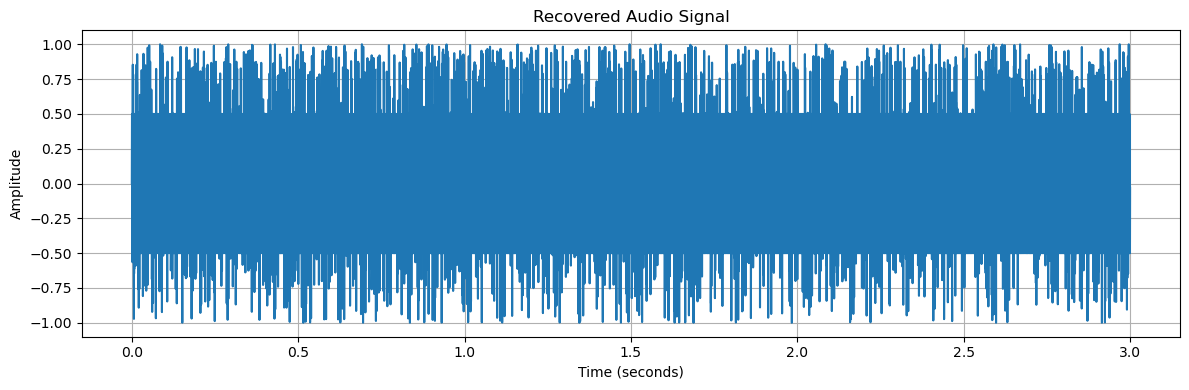

✅ Audio decoded successfully.
✅ Saved to received_output.wav

⚠️ Audio playback disabled (sounddevice module not available)

--- Digital Communication Chat App ---
1. Text Message
2. Audio File (.wav)
3. Exit


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
import os

# Try to import sounddevice, but provide a fallback if it fails
try:
    import sounddevice as sd
    SOUND_DEVICE_AVAILABLE = True
except ImportError:
    print("Warning: sounddevice module not found. Audio playback will be disabled.")
    SOUND_DEVICE_AVAILABLE = False

# === Text-Audio Conversion Utilities ===
def text_to_bits(text):
    return np.array([int(b) for char in text for b in format(ord(char), '08b')])

def bits_to_text(bits):
    # Ensure bits length is a multiple of 8 for proper character conversion
    bits = bits[:len(bits) - len(bits) % 8]
    chars = [bits[i:i + 8] for i in range(0, len(bits), 8)]
    return ''.join([chr(int(''.join(str(int(b)) for b in byte), 2)) for byte in chars])

def audio_to_bits(audio, sample_width=16):
    audio = np.clip(audio, -1.0, 1.0)
    scaled = (audio * 32767).astype(np.int16)
    return np.unpackbits(scaled.view(np.uint8))

def bits_to_audio(bits, sample_rate, sample_width=16):
    if len(bits) % 8 != 0:
        bits = bits[:len(bits) - len(bits) % 8]

    byte_data = np.packbits(bits)
    audio = np.frombuffer(byte_data, dtype=np.int16).astype(np.float32)
    audio /= 32768.0
    return audio, sample_rate

# === Hamming(7,4) Encoding and Decoding ===
def hamming_encode(data_bits):
    encoded = []
    for i in range(0, len(data_bits), 4):
        d = data_bits[i:i + 4]
        while len(d) < 4:
            d = np.append(d, 0)
        d1, d2, d3, d4 = d
        p1 = (d1 ^ d2 ^ d4) & 1  # Ensure binary values
        p2 = (d1 ^ d3 ^ d4) & 1
        p3 = (d2 ^ d3 ^ d4) & 1
        encoded += [p1, p2, d1, p3, d2, d3, d4]
    return np.array(encoded, dtype=int)

def hamming_decode(encoded_bits):
    decoded = []
    for i in range(0, len(encoded_bits), 7):
        block = encoded_bits[i:i + 7]
        if len(block) < 7:
            continue
        p1, p2, d1, p3, d2, d3, d4 = block
        s1 = (p1 ^ d1 ^ d2 ^ d4) & 1
        s2 = (p2 ^ d1 ^ d3 ^ d4) & 1
        s3 = (p3 ^ d2 ^ d3 ^ d4) & 1
        error_pos = s1 + (s2 * 2) + (s3 * 4)  # Changed << to * for clarity
        if error_pos != 0 and error_pos <= 7:
            block[error_pos - 1] ^= 1
        decoded += [block[2], block[4], block[5], block[6]]
    return np.array(decoded, dtype=int)

# === Modulation/Demodulation ===
def bpsk_modulate(bits):
    return 2 * bits.astype(float) - 1  # Ensure float output for BPSK

def bpsk_demodulate(signal):
    return (signal.real >= 0).astype(int)

def qpsk_modulate(bits):
    # Ensure bits length is even
    if len(bits) % 2 != 0:
        bits = np.append(bits, 0)
    symbols = []
    for i in range(0, len(bits), 2):
        if i + 1 < len(bits):  # Check to prevent index out of bounds
            b1, b2 = bits[i], bits[i + 1]
            I = 1 if b1 == 1 else -1
            Q = 1 if b2 == 1 else -1
            symbols.append(I + 1j * Q)
    return np.array(symbols)

def qpsk_demodulate(symbols):
    bits = []
    for sym in symbols:
        bits.append(1 if sym.real >= 0 else 0)
        bits.append(1 if sym.imag >= 0 else 0)
    return np.array(bits, dtype=int)

def qam16_modulate(bits):
    # Ensure bits length is a multiple of 4
    if len(bits) % 4 != 0:
        padding = 4 - (len(bits) % 4)
        bits = np.append(bits, np.zeros(padding, dtype=int))
    
    mapping = {
        (0, 0): -3,
        (0, 1): -1,
        (1, 1): 1,
        (1, 0): 3
    }
    symbols = []
    for i in range(0, len(bits), 4):
        if i + 3 < len(bits):  # Check to prevent index out of bounds
            b1, b2, b3, b4 = bits[i:i + 4]
            I = mapping[(int(b1), int(b2))]
            Q = mapping[(int(b3), int(b4))]
            symbols.append(I + 1j * Q)
    return np.array(symbols)

def qam16_demodulate(symbols):
    bits = []
    for sym in symbols:
        I = sym.real
        Q = sym.imag
        bits += [1 if I > 0 else 0, 1 if abs(I) < 2 else 0]
        bits += [1 if Q > 0 else 0, 1 if abs(Q) < 2 else 0]
    return np.array(bits, dtype=int)

# === AWGN Channel ===
def add_awgn_noise(signal, EbN0_dB, bits_per_symbol):
    EbN0 = 10 ** (EbN0_dB / 10)
    signal_power = np.mean(np.abs(signal) ** 2)
    noise_power = signal_power / (2 * bits_per_symbol * EbN0)

    if np.iscomplexobj(signal):
        noise = np.sqrt(noise_power) * (np.random.randn(*signal.shape) + 1j * np.random.randn(*signal.shape))
    else:
        noise = np.sqrt(2 * noise_power) * np.random.randn(*signal.shape)

    return signal + noise

# === Improved Plotting Functions ===
def plot_input_signal(signal, sample_rate, title="Input Signal"):
    """Plot the original input signal with proper x-axis in seconds"""
    plt.figure(figsize=(12, 4))
    time = np.arange(0, len(signal)) / sample_rate
    plt.plot(time, signal)
    plt.title(title)
    plt.xlabel("Time (seconds)")
    plt.ylabel("Amplitude")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_bits(bits, title="Bit Sequence"):
    """Plot bits as a digital signal"""
    plt.figure(figsize=(12, 3))
    # Use stem plot for discrete binary values
    plt.stem(np.arange(len(bits)), bits, basefmt=" ", use_line_collection=True)
    plt.title(title)
    plt.xlabel("Bit Index")
    plt.ylabel("Bit Value")
    plt.yticks([0, 1])
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_modulated_signal(signal, title="Modulated Signal", max_points=1000):
    """Plot modulated signal with option to downsample for clarity"""
    plt.figure(figsize=(12, 4))
    
    # If signal is too long, sample it for better visualization
    if len(signal) > max_points:
        # Create an evenly spaced sample of points
        indices = np.linspace(0, len(signal)-1, max_points, dtype=int)
        signal_sampled = signal[indices]
        x_values = indices
    else:
        signal_sampled = signal
        x_values = np.arange(len(signal))
    
    if np.iscomplexobj(signal):
        plt.subplot(2, 1, 1)
        plt.plot(x_values, np.real(signal_sampled))
        plt.title(f"{title} - Real Part")
        plt.ylabel("Amplitude")
        plt.grid(True)
        
        plt.subplot(2, 1, 2)
        plt.plot(x_values, np.imag(signal_sampled))
        plt.title(f"{title} - Imaginary Part")
        plt.xlabel("Sample Index")
        plt.ylabel("Amplitude")
        plt.grid(True)
    else:
        plt.plot(x_values, np.real(signal_sampled))
        plt.title(title)
        plt.xlabel("Sample Index")
        plt.ylabel("Amplitude")
        plt.grid(True)
    
    plt.tight_layout()
    plt.show()

def plot_zoomed_signal(signal, title="Zoomed Signal View", zoom_start=0, zoom_length=100):
    """Plot a zoomed section of the signal to see individual transitions"""
    plt.figure(figsize=(12, 4))
    
    # Ensure we don't go out of bounds
    if zoom_start >= len(signal):
        zoom_start = 0
    if zoom_start + zoom_length > len(signal):
        zoom_length = len(signal) - zoom_start
        
    zoom_end = zoom_start + zoom_length
    x_values = np.arange(zoom_start, zoom_end)
    
    if np.iscomplexobj(signal):
        plt.subplot(2, 1, 1)
        plt.plot(x_values, np.real(signal[zoom_start:zoom_end]))
        plt.title(f"{title} - Real Part (samples {zoom_start}-{zoom_end})")
        plt.ylabel("Amplitude")
        plt.grid(True)
        
        plt.subplot(2, 1, 2)
        plt.plot(x_values, np.imag(signal[zoom_start:zoom_end]))
        plt.title(f"{title} - Imaginary Part (samples {zoom_start}-{zoom_end})")
        plt.xlabel("Sample Index")
        plt.ylabel("Amplitude")
        plt.grid(True)
    else:
        plt.plot(x_values, np.real(signal[zoom_start:zoom_end]))
        plt.title(f"{title} (samples {zoom_start}-{zoom_end})")
        plt.xlabel("Sample Index")
        plt.ylabel("Amplitude")
        plt.grid(True)
    
    plt.tight_layout()
    plt.show()

def plot_constellation(symbols, title="Constellation Diagram"):
    """Plot constellation diagram for complex signals (QPSK, QAM)"""
    if not np.iscomplexobj(symbols):
        return  # Only for complex signals
        
    plt.figure(figsize=(8, 8))
    plt.scatter(np.real(symbols), np.imag(symbols), alpha=0.5)
    plt.title(title)
    plt.xlabel("In-Phase (I)")
    plt.ylabel("Quadrature (Q)")
    plt.grid(True)
    plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
    plt.axvline(x=0, color='k', linestyle='-', alpha=0.3)
    plt.axis('equal')
    plt.tight_layout()
    plt.show()

def plot_signal_comparison(original, noisy, title="Signal Comparison"):
    """Plot original and noisy signals side by side for comparison"""
    # Sample the signals if they're very long
    max_points = 1000
    if len(original) > max_points:
        indices = np.linspace(0, len(original)-1, max_points, dtype=int)
        original_sampled = original[indices]
        noisy_sampled = noisy[indices] if len(noisy) == len(original) else noisy
        x_values = indices
    else:
        original_sampled = original
        noisy_sampled = noisy
        x_values = np.arange(len(original))
    
    plt.figure(figsize=(12, 6))
    
    if np.iscomplexobj(original):
        # For complex signals - plot real parts
        plt.subplot(2, 1, 1)
        plt.plot(x_values, np.real(original_sampled), label='Original')
        plt.plot(x_values, np.real(noisy_sampled), label='With Noise', alpha=0.7)
        plt.title(f"{title} - Real Part")
        plt.ylabel("Amplitude")
        plt.grid(True)
        plt.legend()
        
        # Plot imaginary parts
        plt.subplot(2, 1, 2)
        plt.plot(x_values, np.imag(original_sampled), label='Original')
        plt.plot(x_values, np.imag(noisy_sampled), label='With Noise', alpha=0.7)
        plt.title(f"{title} - Imaginary Part")
        plt.xlabel("Sample Index")
        plt.ylabel("Amplitude")
        plt.grid(True)
        plt.legend()
    else:
        # For real signals
        plt.plot(x_values, np.real(original_sampled), label='Original')
        plt.plot(x_values, np.real(noisy_sampled), label='With Noise', alpha=0.7)
        plt.title(title)
        plt.xlabel("Sample Index")
        plt.ylabel("Amplitude")
        plt.grid(True)
        plt.legend()
    
    plt.tight_layout()
    plt.show()

# === Main Chat Loop ===
def main():
    while True:
        print("\n--- Digital Communication Chat App ---")
        print("1. Text Message\n2. Audio File (.wav)\n3. Exit")
        mode = input("Enter choice (1, 2, or 3): ")

        if mode == '3':
            print("Exiting the chat app. Goodbye!")
            break

        # === Input Message or Audio ===
        if mode == '1':
            message = input("You: ")
            bits = text_to_bits(message)
            file_mode = 'text'
            sample_rate = None
            input_signal = None
        elif mode == '2':
            file_path = input("Enter path to .wav file: ").strip()
            if not os.path.exists(file_path):
                print("File not found.")
                continue
            try:
                sample_rate, audio = wavfile.read(file_path)
                if audio.ndim > 1:
                    audio = audio[:, 0]  # Use only one channel
                audio = audio.astype(np.float32) / 32768
                input_signal = audio  # Store the input signal for plotting
                
                # Plot the input audio signal
                plot_input_signal(audio, sample_rate, f"Input Audio: {os.path.basename(file_path)}")
                
                bits = audio_to_bits(audio)
                file_mode = 'audio'
            except Exception as e:
                print(f"Error reading audio file: {e}")
                continue
        else:
            print("Invalid option. Try again.")
            continue

        # Plot the raw bit sequence (subset for large files)
        if len(bits) > 1000:
            plot_bits(bits[:1000], "First 1000 Bits of Input")
        else:
            plot_bits(bits, "Input Bits")

        # === Hamming Encoding ===
        encoded = hamming_encode(bits)
        
        # Plot encoded bits (subset)
        if len(encoded) > 1000:
            plot_bits(encoded[:1000], "First 1000 Bits After Hamming Encoding")
        else:
            plot_bits(encoded, "Hamming Encoded Bits")

        # === Modulation Type ===
        print("\nSelect Modulation:")
        print("1. BPSK\n2. QPSK\n3. 16-QAM")
        mod_choice = input("Enter choice (1/2/3): ")
        
        if mod_choice not in ['1', '2', '3']:
            print("Invalid modulation choice. Using BPSK by default.")
            mod_choice = '1'

        # Input validation for Eb/N0
        EbN0_dB = 5.0  # Default value
        while True:
            try:
                EbN0_input = input("Enter Eb/N0 in dB (recommended 2–10, press Enter for default 5dB): ")
                if not EbN0_input:
                    break  # Use default
                EbN0_dB = float(EbN0_input)
                if 0 <= EbN0_dB <= 20:
                    break
                else:
                    print("Value out of range (0-20 dB).")
            except ValueError:
                print("Invalid input. Please enter a number.")

        # === Modulate ===
        modulation_name = ""
        if mod_choice == '1':
            modulated = bpsk_modulate(encoded)
            bits_per_symbol = 1
            modulation_name = "BPSK"
        elif mod_choice == '2':
            modulated = qpsk_modulate(encoded)
            bits_per_symbol = 2
            modulation_name = "QPSK"
        elif mod_choice == '3':
            modulated = qam16_modulate(encoded)
            bits_per_symbol = 4
            modulation_name = "16-QAM"

        # Plot the modulated signal
        plot_modulated_signal(modulated, f"{modulation_name} Modulated Signal (Full)")
        
        # Plot zoomed section to see transitions
        plot_zoomed_signal(modulated, f"{modulation_name} Modulated Signal (Zoomed)", 0, 100)
        
        # For QPSK and QAM, plot constellation diagram
        if mod_choice in ['2', '3']:
            plot_constellation(modulated, f"{modulation_name} Constellation Diagram")

        # === Transmit Over Channel ===
        noisy = add_awgn_noise(modulated, EbN0_dB, bits_per_symbol)

        # Plot comparison and constellation of received signal
        plot_signal_comparison(modulated, noisy, f"Original vs Noisy Signal (Eb/N0={EbN0_dB}dB)")
        
        if mod_choice in ['2', '3']:
            plot_constellation(noisy, f"{modulation_name} Constellation with Noise (Eb/N0={EbN0_dB}dB)")

        # === Demodulate ===
        if mod_choice == '1':
            demodulated = bpsk_demodulate(noisy)
        elif mod_choice == '2':
            demodulated = qpsk_demodulate(noisy)
        elif mod_choice == '3':
            demodulated = qam16_demodulate(noisy)

        # Plot demodulated bits (subset)
        if len(demodulated) > 1000:
            plot_bits(demodulated[:1000], "First 1000 Demodulated Bits")
        else:
            plot_bits(demodulated, "Demodulated Bits")

        # === Decode ===
        decoded = hamming_decode(demodulated)

        # === Output ===
        if file_mode == 'text':
            try:
                received_msg = bits_to_text(decoded)
                print(f"\n🛰️ Received Message: {received_msg}")
            except Exception as e:
                print(f"Error decoding message: {e}")
        elif file_mode == 'audio':
            try:
                received_audio, sr = bits_to_audio(decoded, sample_rate)
                if received_audio.size == 0:
                    print("⚠️ Received audio is empty. Possibly due to noise or decoding errors.")
                    continue

                received_audio = np.clip(received_audio, -1.0, 1.0)

                # Plot the recovered audio signal
                plot_input_signal(received_audio, sr, "Recovered Audio Signal")

                if np.max(np.abs(received_audio)) < 1e-3:
                    print("⚠️ Received audio is nearly silent.")
                else:
                    print("✅ Audio decoded successfully.")

                output_file = "received_output.wav"
                wavfile.write(output_file, sr, (received_audio * 32767).astype(np.int16))

                print(f"✅ Saved to {output_file}")
                
                # Play audio only if sounddevice is available
                if SOUND_DEVICE_AVAILABLE:
                    print(f"\n🔊 Playing received audio...")
                    try:
                        sd.play(received_audio, sr)
                        sd.wait()
                    except Exception as e:
                        print(f"Error playing audio: {e}")
                else:
                    print("\n⚠️ Audio playback disabled (sounddevice module not available)")
            except Exception as e:
                print(f"Error processing audio: {e}")

if __name__ == "__main__":
    main()